# Import

In [8]:
# !pip install contractions

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/Compiler/gcccore/11.2.0/python/3.9.6/bin/python3.9 -m pip install --upgrade pip' command.


In [2]:
import bz2
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import shutil

from torch.utils.data import Dataset, DataLoader

import nltk
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
# from torchtext.vocab import build_vocab_from_iterator

import matplotlib.pyplot as plt
import seaborn as sns
import json
import random
from collections import Counter
import numpy as np
from torch.nn.utils.rnn import pad_sequence
import torch
from torch import nn

from torch.utils.data import TensorDataset, DataLoader, random_split
# import torchtext

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn import metrics
import gc
import collections

import sys
sys.path.append('../')

import contractions

import re
import gc
import pickle



#The essentials
STOPWORDS = set(stopwords.words("english"))
print('stopwords = ', STOPWORDS)

import bz2

[nltk_data] Downloading package stopwords to
[nltk_data]     /user/jatinjay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


stopwords =  {'mightn', 'those', 'can', 'their', 'haven', 'against', "should've", 'do', 'about', 'hasn', 'during', 'yourselves', "won't", 've', 'where', "don't", 'myself', 'ma', 'aren', 'they', 'his', 'd', 'it', 'he', 'theirs', 'being', "hadn't", 'having', 'above', 'of', "hasn't", 'by', 'you', 'than', "isn't", 's', 'themselves', 'this', 'for', 'under', 'am', 'have', 'and', 'mustn', 'only', 'further', 'until', 'as', 'why', "needn't", "she's", 'or', 'at', 'more', "didn't", 'through', 'when', 'she', 'itself', 'below', 'him', "wouldn't", 'shan', 'don', 'hers', "mightn't", 'doing', 'y', 'has', 'not', 'out', 'did', 'which', 'its', 'once', 'few', "weren't", 'same', 'hadn', 'isn', 'each', 'very', 'were', 'shouldn', 're', 'won', "shan't", 'because', 'all', 'be', 'had', 'down', 'off', "you'd", "haven't", 'weren', 'the', "shouldn't", 'on', "doesn't", 'a', 'ours', "it's", 'but', 'after', 'in', "you're", 'into', 'your', 'if', 'should', 'just', 'wasn', 'wouldn', 'o', 'both', 'while', 'couldn', 'no',

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the whole dataset and truncate it (for experiments)

In [7]:
# root = os.getcwd()
# datasetpath = os.path.join(root, 'dataset')
# assert os.path.exists(datasetpath), f'dataset path does not exist {datasetpath}'

In [8]:
# train_txt = bz2.BZ2File(os.path.join(datasetpath, 'train.ft.txt.bz2'))
train_txt = bz2.BZ2File('/content/drive/MyDrive/UB/Sem 2/DL/DL FINAL Project/train.ft.txt.bz2')
train_lines = train_txt.readlines()
# test_txt = bz2.BZ2File(os.path.join(datasetpath, 'test.ft.txt.bz2'))

In [9]:
# train_lines = train_txt.readlines()
del train_txt
gc.collect()

0

In [10]:
for line in train_lines[:5]:
    print(line)

b'__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n'
b"__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.\n"
b'__label__2 Amazing!: This sou

In [11]:
#only tkae 10% of this dataset
LIMIT = int(0.05 * len(train_lines))
print('limit = ', LIMIT)

truncated_train_lines = train_lines[:LIMIT]

TRAIN_RATIO = 0.8
train_len = int(len(truncated_train_lines) * TRAIN_RATIO)

train_array = [x.decode('utf-8') for x in truncated_train_lines[:train_len]]
val_array = [x.decode('utf-8') for x in truncated_train_lines[train_len:]]

#apply limit to a big dataset
train_array = train_array[:LIMIT]

print('train len = ', len(train_array))
print('val len = ', len(val_array))

limit =  180000
train len =  144000
val len =  36000


In [13]:
truncated_file_path = os.path.join(datasetpath, 'truncated_text.csv')
print(type(train_array))
X_array = []
y_array = []
for line in train_array:
    parts = line.split(' ')
    label = parts[0]
    feature = ' '.join(parts[1:])

    X_array.append(feature)
    y_array.append(label)

truncated_text_df = pd.DataFrame({'label':y_array, 'text':X_array})
truncated_text_df.head()

print(truncated_text_df.shape)
truncated_text_df.to_csv(truncated_file_path)

# Process the dataset

- for experiments, work on the truncated_train.ft.txt.bz2 file
- Clean the text here

In [3]:
root = os.getcwd()

# JAMES
# truncated_file_path = "/content/drive/MyDrive/UB school work/Spring 24/DL/DL FINAL Project/truncated_text.csv"

# JATIN
# truncated_file_path = "/content/drive/MyDrive/UB/Sem 2/DL/DL FINAL Project/truncated_text.csv"
truncated_file_path = "truncated_text.csv"

In [4]:
train_df = pd.read_csv(truncated_file_path, index_col=0)
train_df['length'] = train_df['text'].apply(lambda s: len(s))
print(train_df.shape)
train_df.head()
# X_array,y_array,train_df = load_from_csv(truncated_file_path)

(144000, 3)


,label,text,length
0,__label__2,Stuning even for the non-gamer: This sound tra...,427
1,__label__2,The best soundtrack ever to anything.: I'm rea...,510
2,__label__2,Amazing!: This soundtrack is my favorite music...,761
3,__label__2,Excellent Soundtrack: I truly like this soundt...,744
4,__label__2,"Remember, Pull Your Jaw Off The Floor After He...",482


# A little EDA

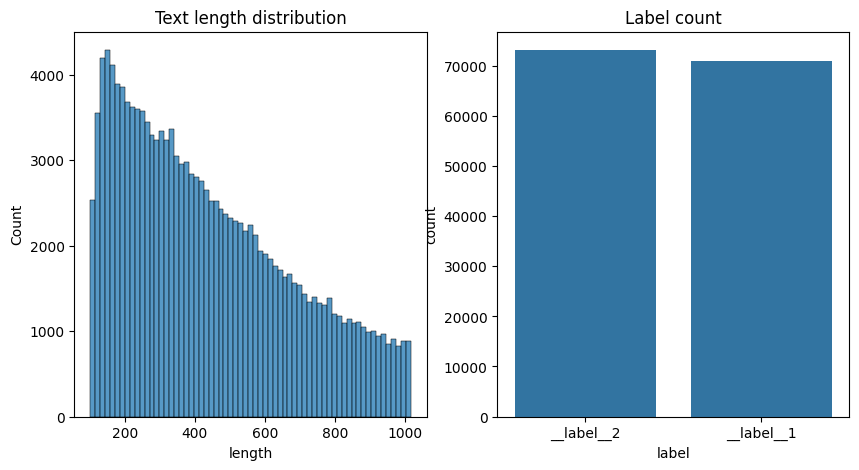

In [ ]:
#plot 2, hist of length
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.histplot(train_df, x = 'length', ax = ax1)
ax1.set_title("Text length distribution")
sns.countplot(train_df, x = 'label', ax = ax2)
ax2.set_title("Label count")
plt.show()

# Build array

In [5]:
# Cleaning Text

def remove_urls(text):
    #if there's link in text, like www.something.com, https://www.something.com,
    # replace it with the <url> token
    pattern = re.compile(r'https?://\S+|www\.\S+')
    text = pattern.sub(' ', text)
    return text

def remove_digits(text):
    return re.sub("\d", ' ', text)

def remove_punctation(text):
    return re.sub(r'[^\w\s]',' ',text)

def expand_contraction(text):
    return contractions.fix(text)

def remove_stopwords(text):
    return ' '.join([word for word in text.split(' ') if word not in STOPWORDS])

def clean_text(text):
    '''
    extract feature and label from line and process the text
    @params:
        text: string, format: __label__2 some text.
    @return:
        feature: string
        label: int, 0: bad review, 1 good review
    '''
    #Each line has format: __label__2 some text.
    #The first part is label, the rest is text feature
    #lower case the features
    text = text.lower()
    #start cleaning

    #remove urls in text
    text = remove_urls(text)
    #remove digits
    text = remove_digits(text)
    # # #expand contractions
    text = expand_contraction(text)
    # # #remove punctuations
    text = remove_punctation(text)
    # # #remove stop words
    text = remove_stopwords(text)

    #__label__1 = 0: bad review, __label__2 = 1,good review
    text = ' '.join(t for t in text.split() if t != '')
    return text.strip()

test_string = '''This is a test string. Here are some special characters: &,#,$. How about some punctuations? !@#$%^&*()_+=-`~{[]}|:;'<,>.?/"|https://www.example.com'''

clean_text(test_string)

'test string special characters punctuations _'

In [6]:
train_df['target'] = train_df['label'].apply(lambda x: 1 if x == '__label__2' else 0)

In [23]:
train_df['clean_text'] = train_df['text'].apply(lambda x: clean_text(x))

In [24]:
train_df['target'].value_counts()

1    73146
0    70854
Name: target, dtype: int64

In [25]:
train_df.head(5)

,label,text,length,target,clean_text
0,__label__2,Stuning even for the non-gamer: This sound tra...,427,1,stuning even non gamer sound track beautiful p...
1,__label__2,The best soundtrack ever to anything.: I'm rea...,510,1,best soundtrack ever anything reading lot revi...
2,__label__2,Amazing!: This soundtrack is my favorite music...,761,1,amazing soundtrack favorite music time hands i...
3,__label__2,Excellent Soundtrack: I truly like this soundt...,744,1,excellent soundtrack truly like soundtrack enj...
4,__label__2,"Remember, Pull Your Jaw Off The Floor After He...",482,1,remember pull jaw floor hearing played game kn...


**BERT**

In [26]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
import pandas as pd
import torch.nn.utils.rnn as rnn_utils

In [27]:
tr_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42)
tr_df, val_df = train_test_split(tr_df, test_size=0.2, random_state=42)

In [28]:
class AmazonReviewDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=512):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        review = self.df['clean_text'].iloc[idx]
        label = self.df['target'].iloc[idx]
#         print('idx', idx)

        # Tokenize the review
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]

    input_ids = rnn_utils.pad_sequence(input_ids, batch_first=True)
    attention_mask = rnn_utils.pad_sequence(attention_mask, batch_first=True)
    labels = torch.tensor(labels)
#     print(len(input_ids), len(attention_mask), len(labels))

    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

In [29]:
model_name = 'prajjwal1/bert-mini'

In [30]:
tokenizer = BertTokenizer.from_pretrained(model_name)

In [14]:
indices = [3332, 8107, 69566, 25697, 86807, 26598, 37591, 29156]

# Iterate over each index and print the required information
for idx in indices:
    if idx in tr_df.index:  # Check if the index exists in the DataFrame
        text = tr_df['text'][idx]
        target = tr_df['target'][idx]
        text_length = len(text)
        print(f"Index {idx}:")
        print(f"Text: {text}")
        print(f"Length of Text: {text_length}")
        print(f"Target: {target}\n")
    else:
        print(f"Index {idx} not in DataFrame.\n")


Index 3332:
Text: hi-tec mens altitude IV: great boots even works great while walking up wet boards!!! buy this product you will not be sorry, well made and true to size.

Length of Text: 153
Target: 1

Index 8107:
Text: ORIGINAL MUCH BETTER: THE ORIGINIAL OF THIS MOVIE WAS MUCH BETTER. THE SPECIAL EFFECTS IN THIS REMAKE ARE BETTER-BUT THE PLOT IS NOTHING LIKE THE ORIGINAL.

Length of Text: 156
Target: 0

Index 69566:
Text: GOOD QUALITY--POOR COLOR: COLORS ARE BASIC IN MOST INDUSTRY. BONE IS A BASIC COLOR & CUSTOMER IS NOT HAPPY WITH THE YELLOW TONE

Length of Text: 128
Target: 0

Index 25697:
Text: TRUTH: this film was funded by the centeral intelligence agency in the 1950s and was maipulated to suit the need of a capitalistic propoganda machine

Length of Text: 150
Target: 0

Index 86807:
Text: A thought provoking charmer: Who wouldn't be charmed by a tale of life in a stress free utopia where life is long and there is time to pursue the better things in life? However, in the lamasta

In [31]:
train_dataset = AmazonReviewDataset(tr_df, tokenizer)
val_dataset = AmazonReviewDataset(val_df, tokenizer)
test_dataset = AmazonReviewDataset(test_df, tokenizer)

In [32]:
train_loader = DataLoader(train_dataset, batch_size=8, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, collate_fn=collate_fn)

In [33]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-mini and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 256, padding_idx=0)
      (position_embeddings): Embedding(512, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): LayerNorm((256,), eps=1e-12, element

In [35]:
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 5

In [36]:
from tqdm import tqdm

In [37]:
device
device_name = torch.cuda.get_device_name(torch.cuda.current_device())
print("CUDA Device Name:", device_name)

CUDA Device Name: Tesla V100-PCIE-32GB


In [38]:
import torch

for epoch in range(num_epochs):
    # Training loop
    model.train()
    total_loss = 0

    with tqdm(train_loader, unit="batch") as tepoch:
        for batch in tepoch:
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            output = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = output.loss

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            tepoch.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {}')

    # Validation loop
    model.eval()
    val_loss = 0
    val_accuracy = 0

    with torch.no_grad():
        with tqdm(val_loader, unit="batch") as tval:
            for batch in tval:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                output = model(input_ids, attention_mask=attention_mask, labels=labels)
                val_loss += output.loss.item()

                logits = output.logits
                predictions = torch.argmax(logits, dim=1)
                val_accuracy += (predictions == labels).sum().item() / len(labels)

                tval.set_postfix(loss=output.loss.item())

    avg_val_loss = val_loss / len(val_loader)
    avg_val_accuracy = val_accuracy / len(val_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy:.4f}')

100%|██████████| 11520/11520 [09:03<00:00, 21.21batch/s, loss=0.178] 


Epoch 1/5, Training Loss: 0.3078


100%|██████████| 2880/2880 [00:56<00:00, 50.92batch/s, loss=0.345] 


Epoch 1/5, Validation Loss: 0.2588, Validation Accuracy: 0.8896


100%|██████████| 11520/11520 [09:02<00:00, 21.25batch/s, loss=0.253]  


Epoch 2/5, Training Loss: 0.2293


100%|██████████| 2880/2880 [00:56<00:00, 51.01batch/s, loss=0.311]  


Epoch 2/5, Validation Loss: 0.2400, Validation Accuracy: 0.9009


100%|██████████| 11520/11520 [09:01<00:00, 21.27batch/s, loss=0.148]  


Epoch 3/5, Training Loss: 0.1862


100%|██████████| 2880/2880 [00:56<00:00, 51.04batch/s, loss=0.332]  


Epoch 3/5, Validation Loss: 0.2487, Validation Accuracy: 0.9020


100%|██████████| 11520/11520 [09:02<00:00, 21.25batch/s, loss=0.431]  


Epoch 4/5, Training Loss: 0.1519


100%|██████████| 2880/2880 [00:56<00:00, 51.08batch/s, loss=0.887]  


Epoch 4/5, Validation Loss: 0.2689, Validation Accuracy: 0.9027


100%|██████████| 11520/11520 [09:03<00:00, 21.19batch/s, loss=0.1]    


Epoch 5/5, Training Loss: 0.1223


100%|██████████| 2880/2880 [00:56<00:00, 51.07batch/s, loss=0.759]  

Epoch 5/5, Validation Loss: 0.2897, Validation Accuracy: 0.9010


In [39]:
# Evaluate the model on the test set
model.eval()
test_loss = 0
test_accuracy = 0
with torch.no_grad():
    with tqdm(test_loader, unit="batch") as ttest:
        for batch in ttest:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            output = model(input_ids, attention_mask=attention_mask, labels=labels)
            test_loss += output.loss.item()

            logits = output.logits
            predictions = torch.argmax(logits, dim=1)
            test_accuracy += (predictions == labels).sum().item() / len(labels)

            ttest.set_postfix(loss=output.loss.item())

avg_test_loss = test_loss / len(test_loader)
avg_test_accuracy = test_accuracy / len(test_loader)
print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.4f}')

100%|██████████| 3600/3600 [01:10<00:00, 50.93batch/s, loss=0.0219] 

Test Loss: 0.3085, Test Accuracy: 0.8956


In [ ]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

def build_array(X, maxlength = 256):
    X_tokens = []
    X_lengths = []
    for text in tqdm(X):
        tokens = tokenizer(text)[:maxlength]
        X_tokens.append(tokens)
        X_lengths.append(len(tokens))

    return X_tokens, X_lengths


def get_ids(tokens, vocab):
    ids = vocab.lookup_indices(tokens)
    return torch.tensor(ids)

def build_train_test_data(feature_train, label_train, min_vocab_freq = 5, **kwargs):
    train_tokens, train_lengths = build_array(feature_train)

    unk_token = '<unk>'
    pad_token = '<pad>'
    special_tokens = [unk_token, pad_token]

    vocab = torchtext.vocab.build_vocab_from_iterator(
        train_tokens,
        min_freq=min_vocab_freq,
        specials=special_tokens,
    )

    unk_id = vocab[unk_token]
    pad_id = vocab[unk_token]

    vocab.set_default_index(unk_id)

    print('vocab len = ', len(vocab))

    def convert_to_ids_labels_lengths(token_list, labels, lengths):
        id_list = []

        for tokens in tqdm(token_list):
            ids = get_ids(tokens, vocab)
            id_list.append(ids)

        #convert y to tensor
        labels = torch.tensor([0 if label.strip() == '__label__1' else 1 for label in labels])
        #convert X lengths to tensor
        lengths = torch.tensor(lengths)

        return id_list, labels, lengths

    train_ids, train_y, train_lengths = convert_to_ids_labels_lengths(train_tokens, label_train, train_lengths)

    return (train_tokens, train_ids, train_y, train_lengths), vocab, pad_id

In [ ]:
X_array = train_df['text'].apply(lambda s: clean_text(s)).values
y_array = train_df['label'].values

(train_tokens, train_ids, train_y, train_lengths), vocab, pad_id = build_train_test_data(X_array, y_array)

train_ids = pad_sequence(train_ids, batch_first=True, padding_value=pad_id)

100%|██████████| 144000/144000 [00:03<00:00, 38795.50it/s]


vocab len =  36166


100%|██████████| 144000/144000 [00:03<00:00, 38426.29it/s]


In [ ]:
print(len(set(train_y.tolist())))

2


In [ ]:
for label, token, id, length in zip(train_y[:1], train_tokens[:1], train_ids[:1], train_lengths[:1]):
    print(f'label={label}\ntokens={token}\nlength={length}\nids={id}')

print('vocab len = ', len(vocab))

label=1
tokens=['stuning', 'even', 'non', 'gamer', 'sound', 'track', 'beautiful', 'paints', 'senery', 'mind', 'well', 'would', 'recomend', 'even', 'people', 'hate', 'vid', 'game', 'music', 'played', 'game', 'chrono', 'cross', 'games', 'ever', 'played', 'best', 'music', 'backs', 'away', 'crude', 'keyboarding', 'takes', 'fresher', 'step', 'grate', 'guitars', 'soulful', 'orchestras', 'would', 'impress', 'anyone', 'cares', 'listen', '_']
length=45
ids=tensor([    0,    15,   482,  8732,    91,   348,   240,  6270,     0,   290,
           13,     8,  1525,    15,    40,   492, 14605,   108,    41,   403,
          108, 26318,  1583,   661,    30,   403,    20,    41,  6820,   149,
         3670,     0,   310, 15953,   927,  7954,  3160,  3760, 17565,     8,
         4643,    94,  2140,   221,  7850,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
  

In [ ]:
print('ids shape = ', train_ids.shape )
print('y shape = ', train_y.shape )
print('lengths shape = ', train_lengths.shape)

ids shape =  torch.Size([144000, 173])
y shape =  torch.Size([144000])
lengths shape =  torch.Size([144000])


# Building dataset

In [ ]:
class AmazonReviewDataset(Dataset):

    def __init__(self, ids, labels, lengths):
        self.ids = ids
        self.labels = labels
        self.lengths = lengths

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        return self.ids[idx], self.labels[idx], self.lengths[idx]

NUM_CLASSES = len(set(list(train_y.tolist())))

train_dataset = AmazonReviewDataset(train_ids, train_y, train_lengths)

train_ratio = 0.8
train_len = int(train_ratio * len(train_dataset))
val_len = len(train_dataset) - train_len
train_dataset, val_dataset = random_split(train_dataset,[train_len, val_len])


BATCH_SIZE = 256
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle = True)

print('num class = ', NUM_CLASSES)
print('train dataset len = ', len(train_dataset))
print('train dataloader len = ', len(train_dataloader))
print('val dataset len = ', len(val_dataset))
print('val dataloader len = ', len(val_dataloader))

num class =  2
train dataset len =  115200
train dataloader len =  450
val dataset len =  28800
val dataloader len =  113



# Building model

In [ ]:

class LSTM(nn.Module):
    def __init__(
        self,vocab_size,embedding_dim,hidden_dim,output_dim,n_layers,
        bidirectional,dropout_rate,pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(embedding_dim,hidden_dim,n_layers,bidirectional=bidirectional,dropout=dropout_rate,batch_first=True,)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.apply(self.initialize_weights)

    def initialize_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LSTM):
            for name, param in m.named_parameters():
                if "bias" in name:
                    nn.init.zeros_(param)
                elif "weight" in name:
                    nn.init.orthogonal_(param)

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def forward(self, ids, length):
        embedded = self.dropout(self.embedding(ids))
        embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length, batch_first=True, enforce_sorted=False
        )
        output, (hidden, cell) = self.lstm(embedded)
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
        else:
            hidden = self.dropout(hidden[-1])
        prediction = self.fc(hidden)
        return prediction

In [ ]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for ids, label, length in tqdm(dataloader, desc="training..."):
        ids = ids.to(device)
        length = length
        label = label.to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    for ids, label, length in tqdm(dataloader, desc="evaluating..."):
        ids = ids.to(device)
        length = length
        label = label.to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [ ]:
def tune(model, optimizer, criterion, epochs = 10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"The model has {model.count_parameters()} trainable parameters")

    model = model.to(device)
    criterion = criterion.to(device)
    best_valid_loss = float("inf")
    history = []

    history = collections.defaultdict(list)

    for epoch in range(epochs):
        train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
        val_loss, val_acc = evaluate(val_dataloader, model, criterion, device)
        # test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)
        history["train_losses"].append(train_loss)
        history["train_accs"].append(train_acc)
        history["valid_losses"].append(val_loss)
        history["valid_accs"].append(val_acc)
        # history["test_losses"].append(test_loss)
        # history["test_accs"].append(test_acc)
        # if test_loss < best_valid_loss:
        #     best_valid_loss = test_loss
        #     torch.save(model, f"lstm.checkpoint.pt")
        print(f"epoch: {epoch}")
        print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
        print(f"val_loss: {val_loss:.3f}, valid_acc: {val_acc:.3f}")
        # print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

    return history

def plot(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
    epochs = list(range(len(history['train_accs'])))
    sns.lineplot(y = history["train_accs"],   label ='train accuracy',  x = epochs, ax = ax1)
    sns.lineplot(y = history["valid_accs"],   label ='val accuracy',    x = epochs, ax = ax1)
    # sns.lineplot(y = history["test_accs"],  label ='test accuracy', x = epochs, ax = ax1)
    ax1.set_title("Accuracy")

    sns.lineplot(y = history["train_losses"], label ='train loss', x = epochs, ax = ax2)
    sns.lineplot(y = history["valid_losses"],   label ='val loss', x = epochs, ax = ax2)
    # sns.lineplot(y = history["test_losses"],  label ='test loss', x = epochs, ax = ax2)
    ax2.set_title("Loss")

# Baseline

In [ ]:
vectors = torchtext.vocab.GloVe()
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

.vector_cache/glove.840B.300d.zip: 2.18GB [06:57, 5.21MB/s]                            
100%|█████████▉| 2196016/2196017 [04:58<00:00, 7360.76it/s]


output dim =  2
The model has 14460602 trainable parameters


evaluating...: 100%|██████████| 113/113 [00:03<00:00, 30.15it/s]


epoch: 0
train_loss: 0.324, train_acc: 0.860
val_loss: 0.250, valid_acc: 0.894


evaluating...: 100%|██████████| 113/113 [00:03<00:00, 29.76it/s]


epoch: 1
train_loss: 0.250, train_acc: 0.899
val_loss: 0.248, valid_acc: 0.898


evaluating...: 100%|██████████| 113/113 [00:03<00:00, 29.58it/s]


epoch: 2
train_loss: 0.224, train_acc: 0.910
val_loss: 0.228, valid_acc: 0.905


evaluating...: 100%|██████████| 113/113 [00:03<00:00, 29.73it/s]


epoch: 3
train_loss: 0.202, train_acc: 0.920
val_loss: 0.233, valid_acc: 0.905


evaluating...: 100%|██████████| 113/113 [00:03<00:00, 29.62it/s]


epoch: 4
train_loss: 0.183, train_acc: 0.928
val_loss: 0.231, valid_acc: 0.908


evaluating...: 100%|██████████| 113/113 [00:03<00:00, 29.71it/s]


epoch: 5
train_loss: 0.168, train_acc: 0.935
val_loss: 0.252, valid_acc: 0.906


evaluating...: 100%|██████████| 113/113 [00:03<00:00, 29.51it/s]


epoch: 6
train_loss: 0.151, train_acc: 0.942
val_loss: 0.256, valid_acc: 0.906


evaluating...: 100%|██████████| 113/113 [00:03<00:00, 28.74it/s]


epoch: 7
train_loss: 0.135, train_acc: 0.948
val_loss: 0.273, valid_acc: 0.905


evaluating...: 100%|██████████| 113/113 [00:03<00:00, 28.70it/s]


epoch: 8
train_loss: 0.124, train_acc: 0.953
val_loss: 0.287, valid_acc: 0.902


evaluating...: 100%|██████████| 113/113 [00:03<00:00, 28.78it/s]


epoch: 9
train_loss: 0.110, train_acc: 0.958
val_loss: 0.265, valid_acc: 0.902


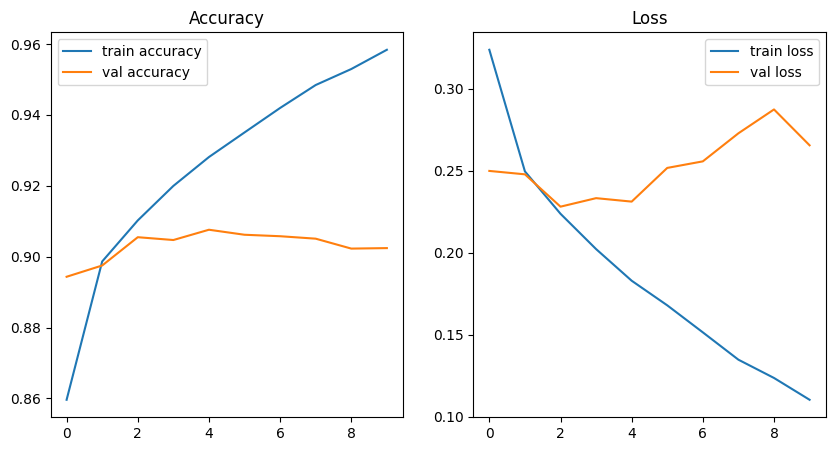

In [ ]:
lr = 5e-4
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = NUM_CLASSES
print('output dim = ', output_dim)
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim  ,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_id,
)

model.embedding.weight.data = pretrained_embedding

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

history = tune(model, optimizer, criterion, epochs = 10)

plot(history)